In [1]:
# Load the Excel file
file_path = "All Data.xlsx"

=== Validated Disaster Forecast System ===
Available disaster types: Storm, Flood, Earthquake, Wildfire, Drought, Extreme temperature, Mass movement (wet), Volcanic activity, Epidemic


C:\Users\milan\AppData\Local\Temp\ipykernel_24956\2942292245.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final.replace([np.inf, -np.inf], np.nan, inplace=True)
C:\Users\milan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)



2025 Forecast: $2808.69 Million


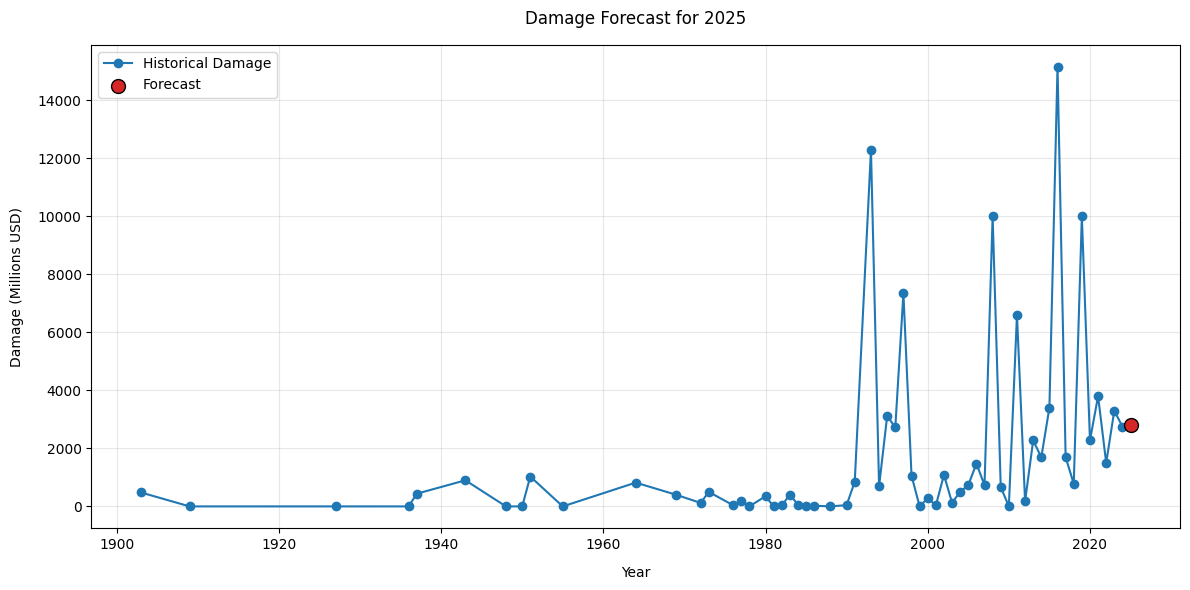

In [1]:
import pandas as pd
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import LinAlgError
from statsmodels.tsa.stattools import adfuller

def load_data(file_path):
    try:
        return pd.read_excel(file_path)
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
        return None

def prepare_series(data, country, disaster_type):
    # Filter and validate data
    filtered = data[(data['ISO'] == country.upper()) & 
                  (data['Disaster Type'] == disaster_type)].copy()
    
    if filtered.empty:
        return None, "No data available"
    
    # Extract valid years
    filtered = filtered.dropna(subset=['Start Year'])
    filtered['Year'] = filtered['Start Year'].astype(int)
    
    # Create annual aggregates
    metrics = ['Total Damage (\'000 US$)', 'Total Affected']
    agg = filtered.groupby('Year')[metrics].sum()
    
    # Convert units
    agg['Damage (Millions)'] = agg['Total Damage (\'000 US$)'] / 1000
    agg['Affected (Millions)'] = agg['Total Affected'] / 1_000_000
    final = agg[['Damage (Millions)', 'Affected (Millions)']]
    
    # Handle zeros as valid entries
    final.replace([np.inf, -np.inf], np.nan, inplace=True)
    final = final.dropna()
    
    return final, None

def check_stationarity(series):
    # Augmented Dickey-Fuller test for stationarity
    result = adfuller(series)
    return result[1] < 0.05  # p-value check

def forecast_damage(data):
    # Automatic differencing
    differenced = data.copy()
    order = 0
    
    while not all(check_stationarity(differenced[col]) for col in differenced.columns):
        differenced = differenced.diff().dropna()
        order += 1
        if order > 2:  # Prevent infinite loop
            return None, "Data cannot be made stationary"
    
    # VAR model with automatic lag selection
    try:
        model = VAR(differenced)
        results = model.fit(maxlags=5, ic='aic')
        lags = results.k_ar
        
        # Forecast and integrate
        forecast_steps = order
        fc = results.forecast(differenced.values[-lags:], forecast_steps)
        
        # Reintegrate differences
        reconstructed = data.values[-1] + fc.cumsum(axis=0)
        return reconstructed[-1][0], None  # Return damage forecast
    except LinAlgError:
        return None, "Numerical instability in matrix operations"
    except Exception as e:
        return None, f"Model error: {str(e)}"

def plot_results(history, forecast, forecast_year):
    plt.figure(figsize=(12, 6))
    
    # Historical data with zeros
    valid_history = history[history['Damage (Millions)'] >= 0]
    plt.plot(valid_history.index, valid_history['Damage (Millions)'], 
            marker='o', linestyle='-', color='#1f77b4', label='Historical Damage')
    
    # Forecast marker
    if forecast is not None:
        plt.scatter(forecast_year, forecast, color='#d62728', s=100,
                   edgecolor='black', zorder=5, label='Forecast')
    
    plt.title(f"Damage Forecast {'for ' + str(forecast_year) if forecast else ''}", pad=15)
    plt.xlabel('Year', labelpad=10)
    plt.ylabel('Damage (Millions USD)', labelpad=10)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

def main():
    print("=== Validated Disaster Forecast System ===")
    data = load_data("All Data.xlsx")
    
    if data is None:
        return
    
    country = input("Enter ISO country code: ").strip().upper()
    disasters = data[data['ISO'] == country]['Disaster Type'].unique()
    
    if not disasters.size:
        print(f"No disaster data for {country}")
        return
    
    print("Available disaster types:", ', '.join(disasters))
    disaster = input("Select disaster type: ").strip()
    
    series, error = prepare_series(data, country, disaster)
    if error:
        print(error)
        return
    
    if len(series) < 10:
        print(f"Warning: Limited data ({len(series)} years). Forecast reliability reduced.")
    
    # Dynamic forecast year
    last_year = series.index.max()
    forecast_year = last_year + 1
    
    forecast, error = forecast_damage(series)
    
    if error:
        print(f"Forecast failed: {error}")
    else:
        print(f"\n{forecast_year} Forecast: ${forecast:.2f} Million")
        plot_results(series, forecast, forecast_year)

if __name__ == "__main__":
    main()


=== Correlation with Total Damage ('000 US$') ===
Total Damage ('000 US$)                      1.000000
Total Damage, Adjusted ('000 US$)            0.969746
Insured Damage ('000 US$)                    0.806849
Insured Damage, Adjusted ('000 US$)          0.803377
Reconstruction Costs, Adjusted ('000 US$)    0.465179
Reconstruction Costs ('000 US$)              0.429487
AID Contribution ('000 US$)                  0.196006
No. Injured                                  0.195123
No. Homeless                                 0.150906
No. Affected                                 0.113906
Total Affected                               0.111586
CPI                                          0.092678
End Year                                     0.088416
Start Year                                   0.088330
Longitude                                    0.053772
Latitude                                     0.053650
Start Day                                    0.013467
Total Deaths                   

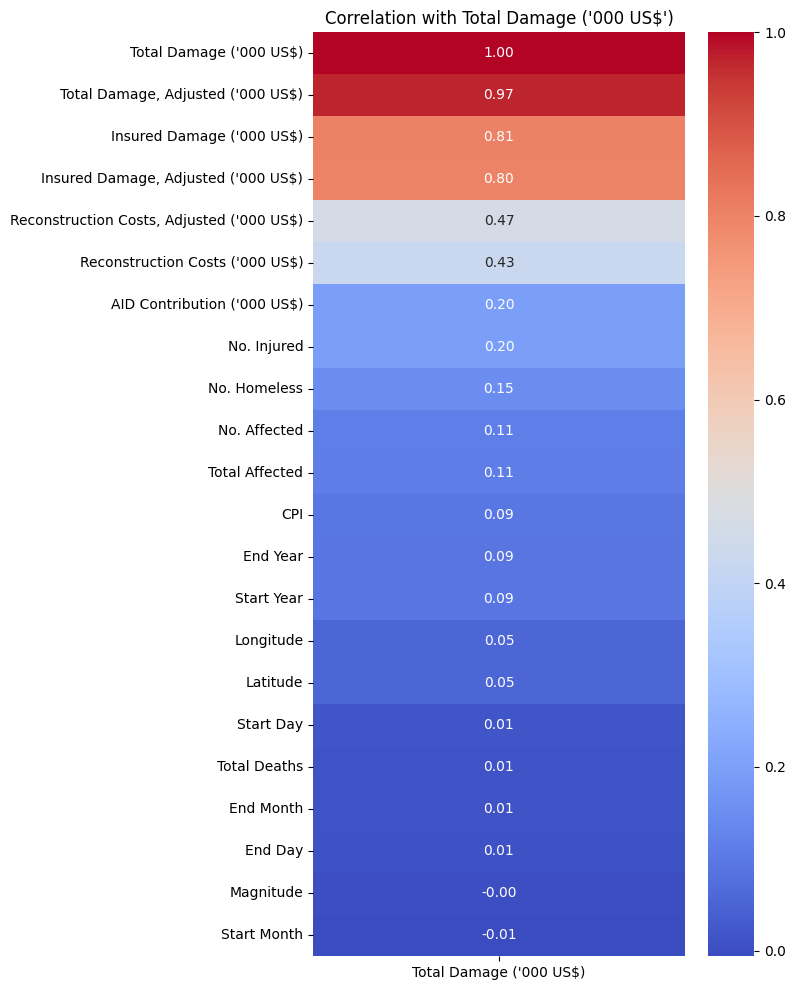

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the Excel file
file_path = "All Data.xlsx"
data = pd.read_excel(file_path)

# Select only numeric columns
numeric_data = data.select_dtypes(include=[np.number])

# Compute correlation with 'Total Damage (\'000 US$)' column
if "Total Damage ('000 US$)" in numeric_data.columns:
    target_column = "Total Damage ('000 US$)"
    correlation_with_target = numeric_data.corr()[target_column].sort_values(ascending=False)
    
    print("\n=== Correlation with Total Damage ('000 US$') ===")
    print(correlation_with_target)

    # Plot heatmap only for correlations with target
    plt.figure(figsize=(6, 12))
    sns.heatmap(correlation_with_target.to_frame(), annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation with Total Damage ('000 US$')")
    plt.show()
else:
    print("Column 'Total Damage ('000 US$)' not found in the dataset.")
